# CTA Transit Feedback Pipeline Demo

This notebook demonstrates the preprocessing and classification pipeline used to:
1. Clean and normalize text
2. Extract CTA routes and transit mentions
3. Classify transit-related content
4. Identify feedback (opinions, experiences)
5. Analyze sentiment
6. Detect sarcasm

## Pipeline Overview

```
    Raw Posts/Comments
            ↓
┌────────────────────────┐
│  Text Preprocessing    │  → Clean text, fix encoding, remove URLs
└────────────────────────┘
            ↓
┌────────────────────────┐
│   Route Extraction     │  → Find train lines and bus routes
└────────────────────────┘
            ↓
┌────────────────────────┐
│ Transit Classification │  → Rule-based + Semantic filtering
└────────────────────────┘
            ↓
┌────────────────────────┐
│ Feedback Classification│  → Identify opinions/experiences
└────────────────────────┘
            ↓
┌────────────────────────┐
│  Sentiment Analysis    │  → Positive/Negative/Neutral
└────────────────────────┘
            ↓
┌────────────────────────┐
│  Sarcasm Detection     │  → Adjust sentiment for sarcasm
└────────────────────────┘
            ↓
  Labeled Feedback Dataset
```

In [46]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
from IPython.display import display, HTML

# Pipeline modules
from cta_pipeline.text_processing import clean_text, preprocess_fn
from cta_pipeline.route_extraction import extract_route_fn
from cta_pipeline.transit_classification import transit_rule_match
from cta_pipeline.feedback_classification import feedback_rule_match, classify_feedback_independently
from cta_pipeline.sentiment_analysis import extract_route_context, adjust_sentiment_for_sarcasm
from cta_pipeline.stop_extraction import detect_sarcasm
from cta_pipeline.time_extraction import extract_time_of_day
from cta_pipeline.constants import (
    TRANSIT_KEYWORDS, FEEDBACK_KEYWORDS, LINE_NAMES, SARCASM_PATTERNS
)

print("Pipeline imports loaded successfully!")

Pipeline imports loaded successfully!


## Sample Data

Let's create sample posts that represent different types of content:

In [47]:
# Sample posts representing different categories
sample_posts = [
    # Transit feedback (should pass all filters)
    "The Red Line was delayed for 30 minutes today. So frustrating! 😤",
    "Bus 66 is always packed during rush hour. CTA needs more buses.",
    "Love taking the Blue Line to O'Hare. Fast and convenient!",
    "The Brown Line stop at Belmont is so dirty. Someone needs to clean it.",
    
    # Sarcastic feedback (should be detected)
    "Gotta love when the CTA train just sits there for no reason.",
    "Thanks CTA for making me late to work again!",
    
    # Transit but not feedback (questions, news)
    "Does the Red Line go to the airport?",
    "CTA announces new bus routes starting Monday.",
    
    # Non-transit content (should be filtered)
    "Great weather in Chicago today!",
    "Trans rights are human rights.",
    
    # Non-CTA transit (should be filtered)
    "Taking Metra to the suburbs today.",
    "Amtrak prices are getting ridiculous.",
    
    # Multiple routes mentioned
    "Transferred from the Red to Blue line at Clark/Lake. Easy connection!",
    "Took bus 49 then the Green Line. Total commute was 45 minutes.",
]

# Create DataFrame
df = pd.DataFrame({
    'text': sample_posts,
    'record_type': ['post'] * len(sample_posts),
    'timestamp': ['2024-01-15T08:30:00'] * len(sample_posts),  # Morning timestamp
})

print(f"Created {len(df)} sample posts")
display(df[['text']].head(6))

Created 14 sample posts


,text
0,The Red Line was delayed for 30 minutes today....
1,Bus 66 is always packed during rush hour. CTA ...
2,Love taking the Blue Line to O'Hare. Fast and ...
3,The Brown Line stop at Belmont is so dirty. So...
4,Gotta love when the CTA train just sits there ...
5,Thanks CTA for making me late to work again!


## Stage 1: Text Preprocessing

Clean text by:
- Fixing encoding issues (mojibake)
- Converting emojis to text
- Removing URLs
- Normalizing whitespace

In [48]:
# Test text cleaning on individual examples
test_texts = [
    "The Red Line was delayed 😤😤😤",
    "Check out https://transitchicago.com for schedules",
    "Multiple   spaces   and\nnewlines",
    "Mojibake: café → cafÃ©",  # Simulated encoding issue
]

print("=== Text Cleaning Examples ===")
for text in test_texts:
    cleaned = clean_text(text)
    print(f"\nOriginal: {text}")
    print(f"Cleaned:  {cleaned}")

=== Text Cleaning Examples ===

Original: The Red Line was delayed 😤😤😤
Cleaned:  The Red Line was delayed :face_with_steam_from_nose::face_with_steam_from_nose::face_with_steam_from_nose:

Original: Check out https://transitchicago.com for schedules
Cleaned:  Check out for schedules

Original: Multiple   spaces   and
newlines
Cleaned:  Multiple spaces and newlines

Original: Mojibake: café → cafÃ©
Cleaned:  Mojibake: café → café


In [49]:
# Apply preprocessing to batch
batch = {'text': df['text'].tolist(), 'combined_text': [None] * len(df), 'is_thread_continuation': [False] * len(df)}
result = preprocess_fn(batch)

df['body'] = result['body']
df['body_lower'] = result['body_lower']

print("=== Preprocessing Results ===")
print(f"Processed {len(df)} texts")
display(df[['text', 'body']].head(4))

=== Preprocessing Results ===
Processed 14 texts


,text,body
0,The Red Line was delayed for 30 minutes today....,The Red Line was delayed for 30 minutes today....
1,Bus 66 is always packed during rush hour. CTA ...,Bus 66 is always packed during rush hour. CTA ...
2,Love taking the Blue Line to O'Hare. Fast and ...,Love taking the Blue Line to O'Hare. Fast and ...
3,The Brown Line stop at Belmont is so dirty. So...,The Brown Line stop at Belmont is so dirty. So...


## Stage 2: Time Extraction

Extract time of day from timestamps for time-based analysis.

The pipeline function expects HuggingFace dataset batches with both `timestamp` and `text` keys. For this demo, we'll use a simplified extraction function.

In [50]:
# The pipeline's extract_time_of_day expects HuggingFace dataset batches.
# For this demo, we use the underlying function directly.
from cta_pipeline.time_extraction import get_time_of_day_from_timestamp

def extract_time_simple(timestamps):
    """Simple time extraction for demo purposes."""
    return [get_time_of_day_from_timestamp(ts) for ts in timestamps]

# Apply time extraction
df['time_of_day'] = extract_time_simple(df['timestamp'].tolist())

print("=== Time of Day Categories ===")
print("  Morning:   5:00 - 11:59")
print("  Afternoon: 12:00 - 16:59")
print("  Evening:   17:00 - 20:59")
print("  Night:     21:00 - 4:59")
print(f"\nExtracted time: {df['time_of_day'].iloc[0]} (from timestamp {df['timestamp'].iloc[0]})")

=== Time of Day Categories ===
  Morning:   5:00 - 11:59
  Afternoon: 12:00 - 16:59
  Evening:   17:00 - 20:59
  Night:     21:00 - 4:59

Extracted time: morning (from timestamp 2024-01-15T08:30:00)


## Stage 3: Route Extraction

Extract CTA routes mentioned in text using pattern matching:
- **Train lines**: red, blue, green, orange, brown, purple, pink, yellow
- **Bus routes**: Numbered routes (e.g., 66, 49, 151)

In [51]:
print("=== Route Extraction Patterns ===")
print(f"Train lines supported: {', '.join(LINE_NAMES)}")
print("\nPattern examples:")
print("  'Red Line' → red_line")
print("  'the blue at Clark' → blue_line")
print("  'red to green transfer' → red_line, green_line")
print("  'bus 66' or '66 bus' → bus_66")
print("  'take the #49' → bus_49")

=== Route Extraction Patterns ===
Train lines supported: red, blue, green, orange, brown, purple, pink, yellow

Pattern examples:
  'Red Line' → red_line
  'the blue at Clark' → blue_line
  'red to green transfer' → red_line, green_line
  'bus 66' or '66 bus' → bus_66
  'take the #49' → bus_49


In [52]:
# Apply route extraction
route_batch = {'body_lower': df['body_lower'].tolist()}
route_result = extract_route_fn(route_batch)

df['routes'] = route_result['routes']
df['route_count'] = route_result['route_count']
df['has_route'] = route_result['has_route']

print("=== Route Extraction Results ===")
routes_found = df['has_route'].sum()
print(f"Posts with routes: {routes_found}/{len(df)} ({routes_found/len(df)*100:.1f}%)")
print(f"Total routes extracted: {df['route_count'].sum()}")
print(f"Multi-route posts: {(df['route_count'] > 1).sum()}")

# Show extraction results
display(df[['body', 'routes', 'has_route']][df['has_route']])

=== Route Extraction Results ===
Posts with routes: 7/14 (50.0%)
Total routes extracted: 9
Multi-route posts: 2


,body,routes,has_route
0,The Red Line was delayed for 30 minutes today....,[red_line],True
1,Bus 66 is always packed during rush hour. CTA ...,[bus_66],True
2,Love taking the Blue Line to O'Hare. Fast and ...,[blue_line],True
3,The Brown Line stop at Belmont is so dirty. So...,[brown_line],True
6,Does the Red Line go to the airport?,[red_line],True
12,Transferred from the Red to Blue line at Clark...,"[blue_line, red_line]",True
13,Took bus 49 then the Green Line. Total commute...,"[green_line, bus_49]",True


## Stage 4: Transit Classification

The pipeline uses a **dual approach** to identify transit-related content:

1. **Rule-based (`is_transit`)**: Keyword pattern matching for CTA-specific terms
2. **Semantic (`is_transit_sem`)**: SBERT embeddings compared against transit anchor phrases

**Final transit criteria**: `is_transit OR is_transit_sem = True`

This ensures we catch both explicit mentions ("CTA bus") and implicit references ("the train was late").

In [53]:
print("=== Transit Keywords ===")
print(f"Keywords: {', '.join(TRANSIT_KEYWORDS[:10])}...")
print(f"Total: {len(TRANSIT_KEYWORDS)} keywords")

=== Transit Keywords ===
Keywords: cta, train, bus, station, subway, the l, the el, l train, red line, blue line...
Total: 16 keywords


In [54]:
# Apply transit rule matching
transit_batch = {'body_lower': df['body_lower'].tolist()}
transit_result = transit_rule_match(transit_batch)

df['is_transit_rule'] = transit_result['is_transit']

print("=== Transit Rule Classification ===")
transit_count = df['is_transit_rule'].sum()
print(f"Transit content: {transit_count}/{len(df)} ({transit_count/len(df)*100:.1f}%)")

# Show classification
print("\nClassified as transit:")
for idx, row in df[df['is_transit_rule']].head(5).iterrows():
    print(f"  ✓ {row['body'][:60]}...")

print("\nNOT classified as transit:")
for idx, row in df[~df['is_transit_rule']].head(3).iterrows():
    print(f"  ✗ {row['body'][:60]}...")

=== Transit Rule Classification ===
Transit content: 10/14 (71.4%)

Classified as transit:
  ✓ The Red Line was delayed for 30 minutes today. So frustratin...
  ✓ Bus 66 is always packed during rush hour. CTA needs more bus...
  ✓ Love taking the Blue Line to O'Hare. Fast and convenient!...
  ✓ The Brown Line stop at Belmont is so dirty. Someone needs to...
  ✓ Gotta love when the CTA train just sits there for no reason....

NOT classified as transit:
  ✗ Great weather in Chicago today!...
  ✗ Trans rights are human rights....
  ✗ Taking Metra to the suburbs today....


### Semantic Transit Classification (`is_transit_sem`)

The semantic classifier uses **sentence-transformers (SBERT)** to compute embeddings and compare against anchor phrases. This catches content that's transit-related but doesn't use explicit keywords.

**How it works:**
1. Compute SBERT embedding of the text
2. Compare against pre-defined transit anchor embeddings
3. Compare against non-transit anchor embeddings  
4. If `transit_score > 0.375` AND `margin > 0.05` AND contains grounding keywords → `is_transit_sem = True`

**Note:** Running semantic classification requires GPU and loading transformer models. In this demo, we simulate the semantic scores.

In [55]:
# Simulate semantic transit classification
# In production, this uses SBERT embeddings from cta_pipeline.transit_classification.is_transit_semantic

from cta_pipeline.constants import SEM_THRESHOLD, SEM_MARGIN, TRANSIT_GROUNDING_KEYWORDS

def simulate_transit_semantic(texts):
    """Simulate semantic transit scores for demo purposes."""
    results = []
    for text in texts:
        text_lower = text.lower()
        # Simulate: higher score if contains transit-like phrases
        transit_phrases = ['train', 'bus', 'line', 'delayed', 'station', 'stop', 'ride', 'commute']
        matches = sum(1 for p in transit_phrases if p in text_lower)
        score = min(0.2 + matches * 0.12, 0.85)
        
        # Check grounding keywords
        has_grounding = any(kw in text_lower for kw in TRANSIT_GROUNDING_KEYWORDS)
        
        # Semantic classification criteria
        is_transit_sem = score > SEM_THRESHOLD and has_grounding
        results.append({'score': score, 'is_transit_sem': is_transit_sem})
    return results

# Apply simulated semantic classification
sem_results = simulate_transit_semantic(df['body'].tolist())
df['transit_score'] = [r['score'] for r in sem_results]
df['is_transit_sem'] = [r['is_transit_sem'] for r in sem_results]

# Combined transit classification
df['is_transit_final'] = df['is_transit_rule'] | df['is_transit_sem']

print("=== Transit Classification Comparison ===")
print(f"{'Method':<20} {'Count':>8} {'Percentage':>12}")
print("-" * 42)
print(f"{'Rule-based only':<20} {df['is_transit_rule'].sum():>8} {df['is_transit_rule'].mean()*100:>11.1f}%")
print(f"{'Semantic only':<20} {df['is_transit_sem'].sum():>8} {df['is_transit_sem'].mean()*100:>11.1f}%")
print(f"{'Combined (OR)':<20} {df['is_transit_final'].sum():>8} {df['is_transit_final'].mean()*100:>11.1f}%")

# Show examples caught by semantic but not rule-based
sem_only = df[df['is_transit_sem'] & ~df['is_transit_rule']]
if not sem_only.empty:
    print(f"\nCaught by semantic but not rule-based ({len(sem_only)}):")
    for _, row in sem_only.head(3).iterrows():
        print(f"  [{row['transit_score']:.2f}] {row['body'][:50]}...")

=== Transit Classification Comparison ===
Method                  Count   Percentage
------------------------------------------
Rule-based only            10        71.4%
Semantic only               3        21.4%
Combined (OR)              10        71.4%


## Stage 5: Feedback Classification

Similar to transit, feedback uses a **dual approach**:

1. **Semantic (`is_feedback_sem`)**: SBERT embeddings compared against feedback/non-feedback anchors
   - Criteria: `fb_score > 0.375` AND `margin > 0.05`
   
2. **Rule-based (`is_feedback`)**: Keyword matching with semantic score threshold
   - Criteria: Matches feedback keywords AND `fb_score > 0.525` AND not a scanner/news post

The semantic classifier runs first to compute `fb_score`, which the rule-based classifier then uses as an additional filter.

In [56]:
print("=== Feedback Keywords ===")
print(f"Keywords: {', '.join(FEEDBACK_KEYWORDS[:15])}...")
print(f"Total: {len(FEEDBACK_KEYWORDS)} keywords")

print("\n=== Feedback Examples ===")
print("  Positive feedback: 'Love taking the train', 'fast and convenient'")
print("  Negative feedback: 'delayed', 'dirty', 'frustrated', 'late'")
print("  NOT feedback: 'Does the train go to...', 'CTA announces...'")

=== Feedback Keywords ===
Keywords: love, like, hate, dislike, despise, delayed, delay, late, slow, slower, crowded, crash, crashed, packed, dangerous...
Total: 43 keywords

=== Feedback Examples ===
  Positive feedback: 'Love taking the train', 'fast and convenient'
  Negative feedback: 'delayed', 'dirty', 'frustrated', 'late'
  NOT feedback: 'Does the train go to...', 'CTA announces...'


In [57]:
# Simulate semantic feedback classification
# In production, uses SBERT embeddings from cta_pipeline.feedback_classification.is_feedback_semantic

from cta_pipeline.constants import FEEDBACK_PATTERN, FEEDBACK_RULE_THRESHOLD

def simulate_feedback_semantic(texts):
    """Simulate semantic feedback scores for demo purposes.
    
    Calibrated to produce realistic scores where clear feedback 
    (opinions, complaints, praise) gets fb_score > 0.525.
    """
    results = []
    for text in texts:
        text_lower = text.lower()
        
        # Strong opinion/experience indicators
        strong_phrases = ['love', 'hate', 'terrible', 'amazing', 'awful', 'best', 'worst', 
                         'frustrated', 'ridiculous', 'unbearable', 'friendly', 'reliable',
                         'convenient', 'annoying', 'horrible', 'fantastic', 'sucks']
        # Moderate feedback signals
        moderate_phrases = ['always', 'never', 'delayed', 'dirty', 'clean', 'packed', 
                           'late', 'slow', 'smooth', 'skipped', 'waiting', 'again',
                           'crowded', 'empty', 'fast', 'quick']
        # Frustration amplifiers
        amplifiers = ['so ', 'very ', 'really ', 'super ', '3rd', '4th', '5th', 
                     'every time', 'once again', 'yet again']
        
        strong_matches = sum(1 for p in strong_phrases if p in text_lower)
        moderate_matches = sum(1 for p in moderate_phrases if p in text_lower)
        amplifier_matches = sum(1 for p in amplifiers if p in text_lower)
        
        # Calculate scores - base score below threshold, need matches to pass
        fb_score = min(0.32 + strong_matches * 0.18 + moderate_matches * 0.10 + amplifier_matches * 0.06, 0.92)
        nf_score = max(0.30 - strong_matches * 0.05 - moderate_matches * 0.02, 0.15)
        
        # Semantic criteria: fb_score > 0.375 AND margin > 0.05
        margin = fb_score - nf_score
        is_feedback_sem = fb_score > SEM_THRESHOLD and margin > SEM_MARGIN
        
        results.append({
            'fb_score': fb_score, 
            'nf_score': nf_score, 
            'margin': margin,
            'is_feedback_sem': is_feedback_sem
        })
    return results

# Apply simulated semantic feedback classification
fb_sem_results = simulate_feedback_semantic(df['body'].tolist())
df['fb_score'] = [r['fb_score'] for r in fb_sem_results]
df['nf_score'] = [r['nf_score'] for r in fb_sem_results]
df['is_feedback_sem'] = [r['is_feedback_sem'] for r in fb_sem_results]

# Apply rule-based feedback (requires fb_score > 0.525)
fb_batch = {
    'body_lower': df['body_lower'].tolist(),
    'fb_score': df['fb_score'].tolist()
}
fb_result = feedback_rule_match(fb_batch)
df['is_feedback'] = fb_result['is_feedback']

print("=== Feedback Classification Comparison ===")
print(f"Semantic threshold: {SEM_THRESHOLD}, Rule threshold: {FEEDBACK_RULE_THRESHOLD}")
print(f"\n{'Method':<25} {'Count':>8} {'Percentage':>12}")
print("-" * 47)
print(f"{'Semantic (is_feedback_sem)':<25} {df['is_feedback_sem'].sum():>8} {df['is_feedback_sem'].mean()*100:>11.1f}%")
print(f"{'Rule-based (is_feedback)':<25} {df['is_feedback'].sum():>8} {df['is_feedback'].mean()*100:>11.1f}%")

# Show feedback scores
print("\n=== Feedback Scores (Top 6 by fb_score) ===")
top_fb = df.nlargest(6, 'fb_score')[['body', 'fb_score', 'is_feedback_sem', 'is_feedback']]
for _, row in top_fb.iterrows():
    sem_flag = "SEM" if row['is_feedback_sem'] else "   "
    rule_flag = "RULE" if row['is_feedback'] else "    "
    print(f"  [{row['fb_score']:.2f}] {sem_flag} {rule_flag} | {row['body'][:45]}...")

=== Feedback Classification Comparison ===
Semantic threshold: 0.375, Rule threshold: 0.525

Method                       Count   Percentage
-----------------------------------------------
Semantic (is_feedback_sem)        7        50.0%
Rule-based (is_feedback)         2        14.3%

=== Feedback Scores (Top 6 by fb_score) ===
  [0.78] SEM RULE | Love taking the Blue Line to O'Hare. Fast and...
  [0.58] SEM RULE | The Brown Line stop at Belmont is so dirty. S...
  [0.52] SEM      | Bus 66 is always packed during rush hour. CTA...
  [0.52] SEM      | Thanks CTA for making me late to work again!...
  [0.50] SEM      | Gotta love when the CTA train just sits there...
  [0.50] SEM      | Amtrak prices are getting ridiculous....


## Stage 6: Sarcasm Detection

Detect sarcastic content that may flip sentiment from positive to negative.

In [58]:
import re

print("=== Sarcasm Detection Patterns ===")
for pattern in SARCASM_PATTERNS:
    # Clean up regex for display
    clean_pattern = pattern.replace(r'\b', '').replace(r'.{0,30}', ' ... ').replace(r'.{0,50}', ' ... ')
    print(f"  • {clean_pattern}")

=== Sarcasm Detection Patterns ===
  • damn i love
  • gotta love ... (cta|train|bus)
  • nothing like ... (smoke|delay|late|stuck)
  • thanks\s+cta
  • (love|loving|great|wonderful|amazing) ... (smoke|smoking|delay|delayed|late|dirty|disgusting|stuck|broken)


In [59]:
# Apply sarcasm detection
df['is_sarcastic'] = df['body'].apply(detect_sarcasm)

print("=== Sarcasm Detection Results ===")
sarcasm_count = df['is_sarcastic'].sum()
print(f"Sarcastic posts: {sarcasm_count}/{len(df)} ({sarcasm_count/len(df)*100:.1f}%)")

if sarcasm_count > 0:
    print("\nDetected sarcasm in:")
    for idx, row in df[df['is_sarcastic']].iterrows():
        print(f"  ⚠️ {row['body'][:70]}...")

=== Sarcasm Detection Results ===
Sarcastic posts: 2/14 (14.3%)

Detected sarcasm in:
  ⚠️ Gotta love when the CTA train just sits there for no reason....
  ⚠️ Thanks CTA for making me late to work again!...


## Stage 7: Route Context Extraction

Extract the sentence(s) containing route mentions for more focused sentiment analysis.

In [60]:
# Demo route context extraction
test_cases = [
    ("I love Chicago. The Red Line is always on time. Great city!", "red_line"),
    ("Took bus 66 today. It was packed. Then walked home.", "bus_66"),
    ("The Blue Line to O'Hare is convenient for travelers.", "blue_line"),
]

print("=== Route Context Extraction ===")
for text, route in test_cases:
    context = extract_route_context(text, route)
    print(f"\nRoute: {route}")
    print(f"Full text: {text}")
    print(f"Context:   {context}")

=== Route Context Extraction ===

Route: red_line
Full text: I love Chicago. The Red Line is always on time. Great city!
Context:   The Red Line is always on time.

Route: bus_66
Full text: Took bus 66 today. It was packed. Then walked home.
Context:   Took bus 66 today.

Route: blue_line
Full text: The Blue Line to O'Hare is convenient for travelers.
Context:   The Blue Line to O'Hare is convenient for travelers.


## Pipeline Performance Summary

Let's summarize the classification results at each stage.

In [61]:
# Calculate metrics at each stage
total = len(df)

# Combined feedback: is_feedback OR is_feedback_sem
df['is_feedback_final'] = df['is_feedback'] | df['is_feedback_sem']

stages = [
    ("Input Posts", total, 100.0),
    ("Has Route", df['has_route'].sum(), df['has_route'].mean() * 100),
    ("Transit (Rule)", df['is_transit_rule'].sum(), df['is_transit_rule'].mean() * 100),
    ("Transit (Semantic)", df['is_transit_sem'].sum(), df['is_transit_sem'].mean() * 100),
    ("Transit (Combined)", df['is_transit_final'].sum(), df['is_transit_final'].mean() * 100),
    ("Feedback (Semantic)", df['is_feedback_sem'].sum(), df['is_feedback_sem'].mean() * 100),
    ("Feedback (Rule)", df['is_feedback'].sum(), df['is_feedback'].mean() * 100),
    ("Sarcastic", df['is_sarcastic'].sum(), df['is_sarcastic'].mean() * 100),
]

print("=" * 65)
print("PIPELINE PERFORMANCE SUMMARY")
print("=" * 65)
print(f"{'Stage':<25} {'Count':>10} {'Percentage':>15}")
print("-" * 65)

for stage, count, pct in stages:
    bar = "█" * int(pct / 5) + "░" * (20 - int(pct / 5))
    print(f"{stage:<25} {count:>10} {pct:>14.1f}% {bar}")

print("-" * 65)
print("\nNote: Transit uses OR logic (rule OR semantic)")
print("      Feedback rule requires fb_score > 0.525")

PIPELINE PERFORMANCE SUMMARY
Stage                          Count      Percentage
-----------------------------------------------------------------
Input Posts                       14          100.0% ████████████████████
Has Route                          7           50.0% ██████████░░░░░░░░░░
Transit (Rule)                    10           71.4% ██████████████░░░░░░
Transit (Semantic)                 3           21.4% ████░░░░░░░░░░░░░░░░
Transit (Combined)                10           71.4% ██████████████░░░░░░
Feedback (Semantic)                7           50.0% ██████████░░░░░░░░░░
Feedback (Rule)                    2           14.3% ██░░░░░░░░░░░░░░░░░░
Sarcastic                          2           14.3% ██░░░░░░░░░░░░░░░░░░
-----------------------------------------------------------------

Note: Transit uses OR logic (rule OR semantic)
      Feedback rule requires fb_score > 0.525


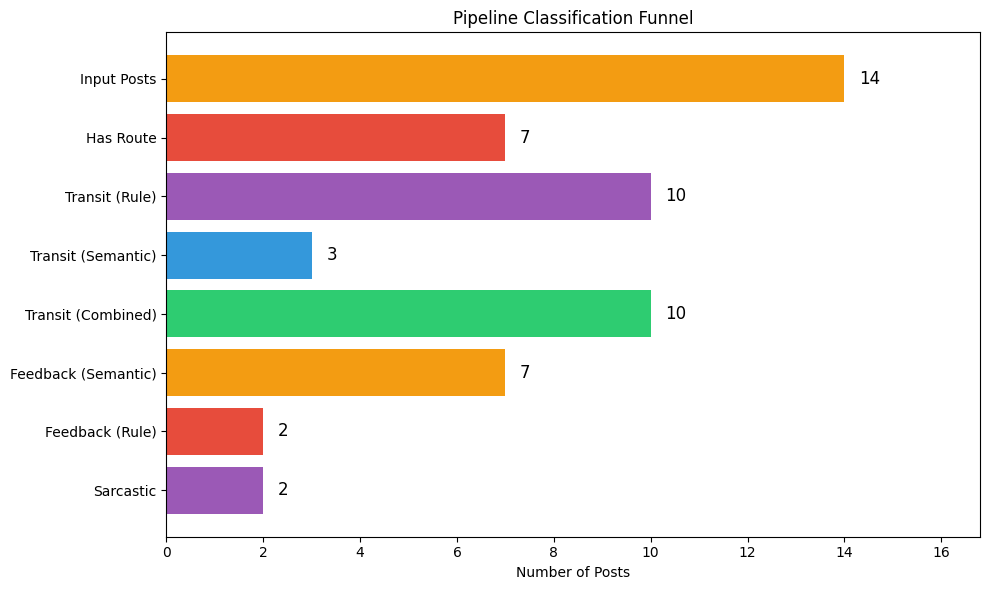

In [62]:
# Visualize the funnel
try:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Funnel data
    stage_names = [s[0] for s in stages]
    counts = [s[1] for s in stages]
    
    # Create horizontal bar chart
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    bars = ax.barh(stage_names[::-1], counts[::-1], color=colors[::-1])
    
    # Add count labels
    for bar, count in zip(bars, counts[::-1]):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{count}', va='center', fontsize=12)
    
    ax.set_xlabel('Number of Posts')
    ax.set_title('Pipeline Classification Funnel')
    ax.set_xlim(0, max(counts) * 1.2)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("matplotlib not available for visualization")

## Route Distribution

In [63]:
# Analyze route distribution
all_routes = [r for routes in df['routes'] for r in routes]
route_counts = pd.Series(all_routes).value_counts()

print("=== Route Distribution ===")
print(f"Total route mentions: {len(all_routes)}")
print(f"Unique routes: {len(route_counts)}")

if len(route_counts) > 0:
    print("\nTop routes:")
    for route, count in route_counts.head(10).items():
        route_type = "🚆" if route.endswith("_line") else "🚌"
        print(f"  {route_type} {route}: {count}")

=== Route Distribution ===
Total route mentions: 9
Unique routes: 6

Top routes:
  🚆 red_line: 3
  🚆 blue_line: 2
  🚌 bus_66: 1
  🚆 brown_line: 1
  🚆 green_line: 1
  🚌 bus_49: 1


## Full Pipeline Test with Simulated Data

Let's run the complete classification on a larger sample.

In [64]:
# Extended sample dataset
extended_posts = [
    # Clear transit feedback
    "Red Line delayed again. 3rd time this week!",
    "The new Blue Line cars are so much cleaner.",
    "Bus 66 driver was super friendly today.",
    "Waited 25 minutes for the Brown Line. Ridiculous.",
    "Love how the Purple Line express skips all the stops.",
    "The Orange Line to Midway is always reliable.",
    "Green Line was packed. Standing room only.",
    "Pink Line smell was unbearable this morning.",
    
    # Bus feedback
    "Bus 49 is the best route on the south side.",
    "The 151 bus is always late.",
    "Took the 22 Clark bus. Smooth ride.",
    "Bus 8 driver skipped my stop!",
    
    # Sarcastic
    "Gotta love waiting 30 mins for a ghost bus on the tracker.",
    "Thanks CTA, really appreciate the smoke-filled car.",
    "Nothing like a delayed train to start your day.",
    
    # Questions (not feedback)
    "How do I get to Wrigley Field from downtown?",
    "Does the Yellow Line run on weekends?",
    "What time is the last Red Line train?",
    
    # News/Announcements (not feedback)
    "CTA to add 20 new buses to the fleet.",
    "Red Line extension project begins next month.",
    "Service alert: Blue Line delays due to signal problems.",
    
    # Non-transit
    "Beautiful day in Chicago!",
    "Going to the Cubs game tonight.",
    "Chicago pizza is the best.",
    
    # Non-CTA transit (should be filtered in production)
    "Metra is so much more comfortable than CTA.",
    "Taking Amtrak to St. Louis tomorrow.",
]

# Process extended dataset
ext_df = pd.DataFrame({
    'text': extended_posts,
    'record_type': ['post'] * len(extended_posts),
})

# Apply pipeline stages
batch = {'text': ext_df['text'].tolist(), 'combined_text': [None] * len(ext_df), 'is_thread_continuation': [False] * len(ext_df)}
result = preprocess_fn(batch)
ext_df['body'] = result['body']
ext_df['body_lower'] = result['body_lower']

route_result = extract_route_fn({'body_lower': ext_df['body_lower'].tolist()})
ext_df['routes'] = route_result['routes']
ext_df['has_route'] = route_result['has_route']

# Transit classification (rule + semantic)
transit_result = transit_rule_match({'body_lower': ext_df['body_lower'].tolist()})
ext_df['is_transit'] = transit_result['is_transit']

sem_results = simulate_transit_semantic(ext_df['body'].tolist())
ext_df['is_transit_sem'] = [r['is_transit_sem'] for r in sem_results]
ext_df['is_transit_final'] = ext_df['is_transit'] | ext_df['is_transit_sem']

# Feedback classification (semantic + rule)
fb_sem_results = simulate_feedback_semantic(ext_df['body'].tolist())
ext_df['fb_score'] = [r['fb_score'] for r in fb_sem_results]
ext_df['is_feedback_sem'] = [r['is_feedback_sem'] for r in fb_sem_results]

fb_result = feedback_rule_match({'body_lower': ext_df['body_lower'].tolist(), 'fb_score': ext_df['fb_score'].tolist()})
ext_df['is_feedback'] = fb_result['is_feedback']
ext_df['is_feedback_final'] = ext_df['is_feedback'] | ext_df['is_feedback_sem']

# Sarcasm
ext_df['is_sarcastic'] = ext_df['body'].apply(detect_sarcasm)

print("=== Extended Pipeline Results ===")
print(f"Total posts: {len(ext_df)}")
print(f"\n{'Classification':<25} {'Count':>8} {'Percentage':>12}")
print("-" * 47)
print(f"{'Has route':<25} {ext_df['has_route'].sum():>8} {ext_df['has_route'].mean()*100:>11.1f}%")
print(f"{'Transit (rule)':<25} {ext_df['is_transit'].sum():>8} {ext_df['is_transit'].mean()*100:>11.1f}%")
print(f"{'Transit (semantic)':<25} {ext_df['is_transit_sem'].sum():>8} {ext_df['is_transit_sem'].mean()*100:>11.1f}%")
print(f"{'Transit (combined)':<25} {ext_df['is_transit_final'].sum():>8} {ext_df['is_transit_final'].mean()*100:>11.1f}%")
print(f"{'Feedback (semantic)':<25} {ext_df['is_feedback_sem'].sum():>8} {ext_df['is_feedback_sem'].mean()*100:>11.1f}%")
print(f"{'Feedback (rule, >0.525)':<25} {ext_df['is_feedback'].sum():>8} {ext_df['is_feedback'].mean()*100:>11.1f}%")
print(f"{'Sarcastic':<25} {ext_df['is_sarcastic'].sum():>8} {ext_df['is_sarcastic'].mean()*100:>11.1f}%")

=== Extended Pipeline Results ===
Total posts: 26

Classification               Count   Percentage
-----------------------------------------------
Has route                       15        57.7%
Transit (rule)                  21        80.8%
Transit (semantic)               6        23.1%
Transit (combined)              21        80.8%
Feedback (semantic)             17        65.4%
Feedback (rule, >0.525)          2         7.7%
Sarcastic                        2         7.7%


In [65]:
# Show classification matrix using correct criteria
# Transit: is_transit OR is_transit_sem
# Feedback: is_feedback (requires fb_score > 0.525) OR is_feedback_sem

print("=== Classification Results ===")
print("Criteria: Transit = (is_transit OR is_transit_sem)")
print("          Feedback = (is_feedback OR is_feedback_sem)")

passed = ext_df[ext_df['is_transit_final'] & ext_df['is_feedback_final']]
print(f"\n✅ PASSED (Transit + Feedback): {len(passed)} posts")
for idx, row in passed.head(8).iterrows():
    sarcasm = " ⚠️ SARCASTIC" if row['is_sarcastic'] else ""
    routes = ', '.join(row['routes']) if row['routes'] else 'no specific route'
    print(f"  [{routes}] {row['body'][:45]}...{sarcasm}")

print(f"\n❌ FILTERED: {len(ext_df) - len(passed)} posts")
filtered = ext_df[~(ext_df['is_transit_final'] & ext_df['is_feedback_final'])].head(6)
for idx, row in filtered.iterrows():
    reasons = []
    if not row['is_transit_final']:
        reasons.append("not transit")
    if not row['is_feedback_final']:
        reasons.append(f"not feedback (fb_score={row['fb_score']:.2f})")
    print(f"  [{', '.join(reasons)}] {row['body'][:45]}...")

=== Classification Results ===
Criteria: Transit = (is_transit OR is_transit_sem)
          Feedback = (is_feedback OR is_feedback_sem)

✅ PASSED (Transit + Feedback): 16 posts
  [red_line] Red Line delayed again. 3rd time this week!...
  [blue_line] The new Blue Line cars are so much cleaner....
  [bus_66] Bus 66 driver was super friendly today....
  [brown_line] Waited 25 minutes for the Brown Line. Ridicul...
  [purple_line] Love how the Purple Line express skips all th...
  [orange_line] The Orange Line to Midway is always reliable....
  [green_line] Green Line was packed. Standing room only....
  [pink_line] Pink Line smell was unbearable this morning....

❌ FILTERED: 10 posts
  [not transit, not feedback (fb_score=0.32)] How do I get to Wrigley Field from downtown?...
  [not feedback (fb_score=0.32)] Does the Yellow Line run on weekends?...
  [not feedback (fb_score=0.32)] What time is the last Red Line train?...
  [not feedback (fb_score=0.32)] CTA to add 20 new buses to the fle

## Running the Full Pipeline

To run the complete pipeline on real data:

### Reddit Pipeline
```bash
python reddit_data_pipe.py
```

Input: `data/posts/reddit/reddit_comments.csv`
Output: `data/processed/reddit/reddit_transit_feedback_labeled.csv`

### Bluesky Pipeline
```bash
python atproto_data_pipe.py
```

Input: `data/posts/bsky/bsky_posts.csv`, `data/posts/bsky/bsky_comments.csv`
Output: `data/processed/bsky/bsky_transit_feedback_labeled.csv`

### Pipeline Stages (17 total)
1. Data Loading
2. Thread Detection
3. Text Preprocessing
4. Time Extraction
5. Route Extraction
6. Route Inheritance
7. Transit Classification (Rule)
8. Transit Classification (Semantic)
9. Feedback Classification (Semantic)
10. Feedback Classification (Rule)
11. Independent Feedback Classification
12. Time Inheritance
13. Route Explosion
14. Route Context Extraction
15. Sentiment Analysis
16. Stop Extraction
17. Sarcasm Detection & Sentiment Adjustment

## Summary

This notebook demonstrated the CTA Transit Feedback Pipeline:

### Classification Stages
1. **Text Preprocessing**: Cleaning, encoding fixes, URL removal
2. **Time Extraction**: Categorizing posts by time of day
3. **Route Extraction**: Pattern matching for train lines and bus routes
4. **Transit Classification**: 
   - Rule-based (`is_transit`): Keyword matching
   - Semantic (`is_transit_sem`): SBERT embeddings vs anchor phrases
   - Combined: `is_transit OR is_transit_sem`
5. **Feedback Classification**:
   - Semantic (`is_feedback_sem`): SBERT embeddings, threshold 0.375
   - Rule-based (`is_feedback`): Keywords + `fb_score > 0.525`
6. **Sarcasm Detection**: Pattern-based identification
7. **Route Context Extraction**: Focusing on route-specific sentences

### Key Thresholds
| Parameter | Value | Description |
|-----------|-------|-------------|
| `SEM_THRESHOLD` | 0.375 | Minimum semantic similarity score |
| `SEM_MARGIN` | 0.05 | Minimum margin between pos/neg scores |
| `FEEDBACK_RULE_THRESHOLD` | 0.525 | Minimum fb_score for rule-based feedback |

### Production Pipeline
The full pipeline (`reddit_data_pipe.py`, `atproto_data_pipe.py`) includes:
- GPU-accelerated SBERT embeddings
- HuggingFace Datasets for efficient batching
- Thread detection for context inheritance
- Sentiment analysis using transformer models
- Stop extraction for location-specific feedback